# Predicting Gender of Shughni Nouns Using Machine Learning Methods

## Modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.sparse import hstack

import warnings
warnings.filterwarnings("ignore")

## Data preparation

### Loading the data

In [2]:
data = pd.merge(
    pd.read_csv("res_subset_sem.csv"),
    pd.read_csv("res_subset_forms.csv").drop_duplicates(subset="unit_id", keep="first"),
    on="unit_id", how="left"
)

In [3]:
data = data[data["meaning_gender"].isin(["m", "f"])]
#data = data.sample(n=1000, random_state=42)

In [4]:
data.shape

(2989, 41)

### Extracting the features

In [5]:
y_pred = {}   # dictionary with predicted values from different features and models
results = {}  # classification reports from different features and models
models = {}   # models used in predictions from different features (necessary to show feature importances)
word_endings = {}
x_transformed = {}

In [6]:
sem_features = ['ind,spec', 'large', 'sex=f', 'animals', 'water',
                'trees', 'fruit', 'tech,transport', 'cultural prod.',
                'mass,abstr', 'small', 'name', 'household objects',
                'food', 'drink', 'plants', 'events', 'pos', 'neg',
                'weather', 'bodyparts', 'buildings', 'landscape', 'sex=m',
                'milk prod.', 'vegetables', 'footwear', 'sicknesses']

vowels = ("a", "ā", "e", "ê", "i", "ī", "o", "u", "ū", "ů")

bad_letters = [("x̌", "X"), ("ɣ̌", "G"), ("ǰ", "j")]

In [7]:
def extract_n_letters(word, n):
    for pair in bad_letters:
        word = re.sub(pair[0], pair[1], word)
    
    if len(word)<n:
        return ""
    
    suffix = ""
    for i in range(len(word)-1, len(word)-n-1, -1):
        if word[i] == "-":
            return ""
        suffix = word[i] + suffix

    for pair in bad_letters:
        suffix = re.sub(pair[1], pair[0], suffix)
    return suffix
    

def last_vowel(word):
    for i in range(len(word)-1, -1, -1):
        if word[i] in vowels:
            return word[i]
    return None

In [8]:
for n in range(2, 7):
    data[f"last_{n}"] = data["form"].apply(lambda x: extract_n_letters(x, n))
    
data["last_vowel"] = data["form"].apply(lambda x: last_vowel(x))

In [9]:
data.head(5)

,meaning_id,unit_id,full_entry,meaning,article_gender,meaning_gender,proper_name,label_id,"ind,spec",large,...,gloss_id,gloss,form,source,last_2,last_3,last_4,last_5,last_6,last_vowel
0,1249,671,"АБЛАГАРИ, АБЛАГИ м. глупость, дурость; ш. абла...","глупость, дурость",m,m,NaN,NaN,0,0,...,20,word,ablagari,2,ri,ari,gari,agari,lagari,i
1,1258,677,"АБОТĀ 1. 1) глупец, дурак, дурачок; ш. йу абот...","глупец, дурак, дурачок",m,m,NaN,NaN,1,0,...,20,word,abotā,2,tā,otā,botā,abotā,,ā
2,1265,681,АБРАЙЕҶ м. ткань для лицевой стороны одежды.,ткань для лицевой стороны одежды,m,m,NaN,NaN,1,0,...,20,word,abrayeǰ,2,eǰ,yeǰ,ayeǰ,rayeǰ,brayeǰ,e
3,1271,687,"шб. АБРЕХ̌УМ, ш. тж. ВИРЕХ̌УМ м. 1) шелк, шелк...","шелк, шелковая ткань; шелковая одежда",m,m,NaN,10.0,1,0,...,20,word,abrex̌um,2,um,x̌um,ex̌um,rex̌um,brex̌um,u
4,1274,689,"А́БРИ, (Ҳ)А́БРÊ м. облако, туча; ш. йида а́бри...","облако, туча",m,m,NaN,NaN,1,1,...,20,word,abri,2,ri,bri,abri,,,i


<Axes: xlabel='meaning_gender', ylabel='Count'>

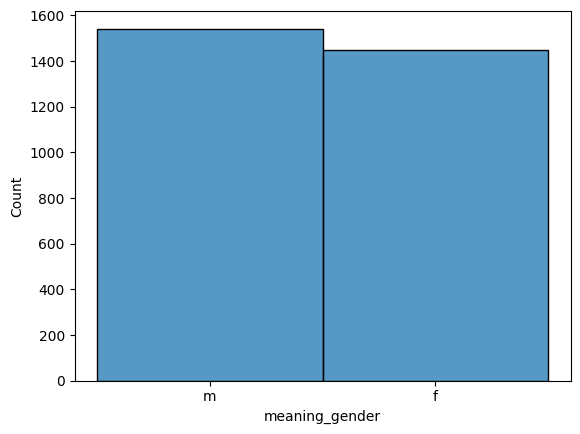

In [10]:
sns.histplot(data["meaning_gender"])

### Exploring the features

In [11]:
data.head(5)

,meaning_id,unit_id,full_entry,meaning,article_gender,meaning_gender,proper_name,label_id,"ind,spec",large,...,gloss_id,gloss,form,source,last_2,last_3,last_4,last_5,last_6,last_vowel
0,1249,671,"АБЛАГАРИ, АБЛАГИ м. глупость, дурость; ш. абла...","глупость, дурость",m,m,NaN,NaN,0,0,...,20,word,ablagari,2,ri,ari,gari,agari,lagari,i
1,1258,677,"АБОТĀ 1. 1) глупец, дурак, дурачок; ш. йу абот...","глупец, дурак, дурачок",m,m,NaN,NaN,1,0,...,20,word,abotā,2,tā,otā,botā,abotā,,ā
2,1265,681,АБРАЙЕҶ м. ткань для лицевой стороны одежды.,ткань для лицевой стороны одежды,m,m,NaN,NaN,1,0,...,20,word,abrayeǰ,2,eǰ,yeǰ,ayeǰ,rayeǰ,brayeǰ,e
3,1271,687,"шб. АБРЕХ̌УМ, ш. тж. ВИРЕХ̌УМ м. 1) шелк, шелк...","шелк, шелковая ткань; шелковая одежда",m,m,NaN,10.0,1,0,...,20,word,abrex̌um,2,um,x̌um,ex̌um,rex̌um,brex̌um,u
4,1274,689,"А́БРИ, (Ҳ)А́БРÊ м. облако, туча; ш. йида а́бри...","облако, туча",m,m,NaN,NaN,1,1,...,20,word,abri,2,ri,bri,abri,,,i


#### Last vowel

<Axes: xlabel='last_vowel', ylabel='Count'>

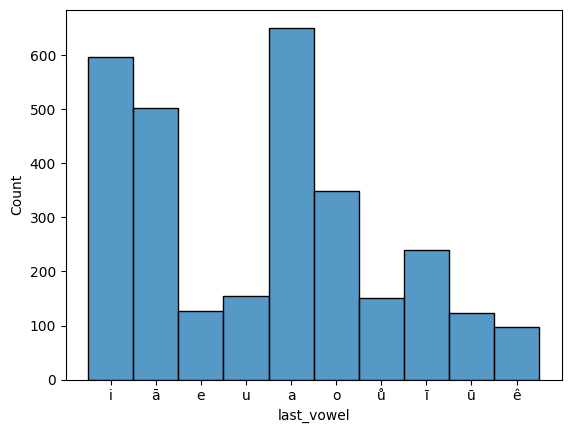

In [12]:
sns.histplot(data["last_vowel"])

<Axes: xlabel='meaning_gender', ylabel='Count'>

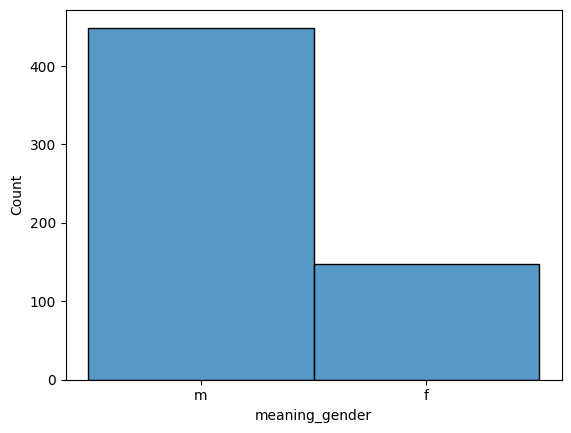

In [13]:
sns.histplot(data[data["last_vowel"]=="i"]["meaning_gender"])

<Axes: xlabel='meaning_gender', ylabel='Count'>

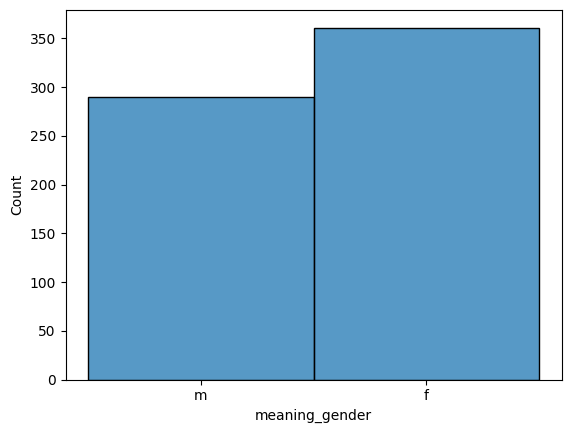

In [14]:
sns.histplot(data[data["last_vowel"]=="a"]["meaning_gender"])

#### Last 2

<Axes: xlabel='last_2', ylabel='count'>

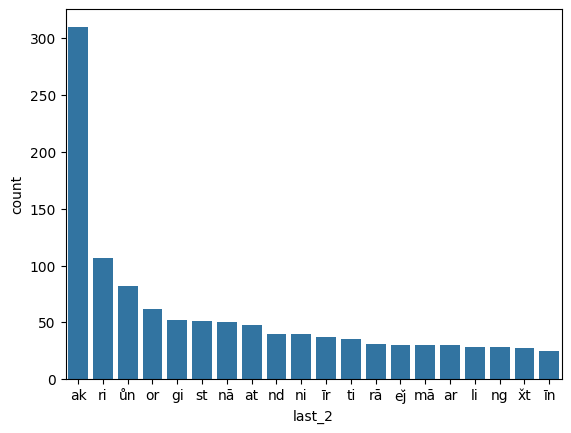

In [15]:
sns.barplot(data["last_2"].value_counts()[:20])

<Axes: xlabel='meaning_gender', ylabel='Count'>

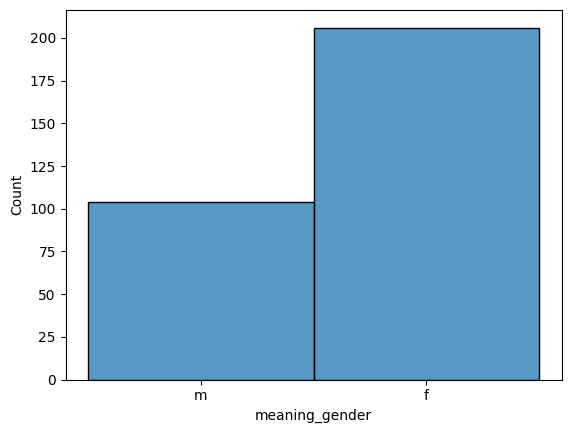

In [16]:
sns.histplot(data[data["last_2"]=="ak"]["meaning_gender"])

<Axes: xlabel='meaning_gender', ylabel='Count'>

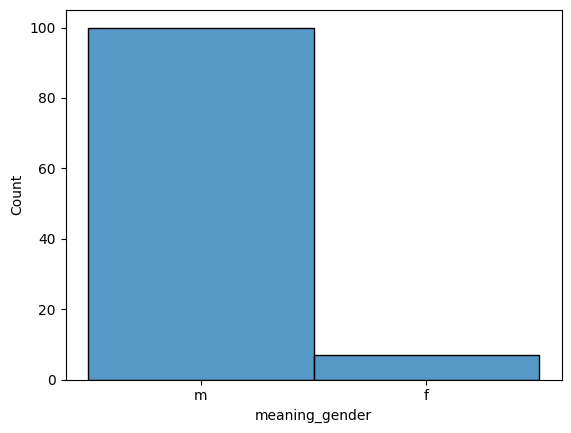

In [17]:
sns.histplot(data[data["last_2"]=="ri"]["meaning_gender"])

#### Semantic features

<Axes: xlabel='meaning_gender', ylabel='Count'>

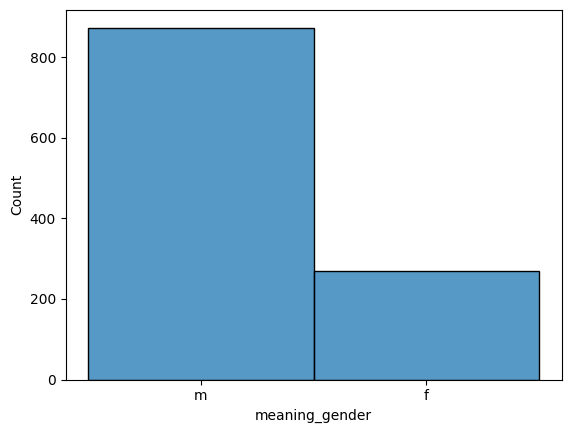

In [18]:
sns.histplot(data[data["mass,abstr"]==1]["meaning_gender"])

<Axes: xlabel='meaning_gender', ylabel='Count'>

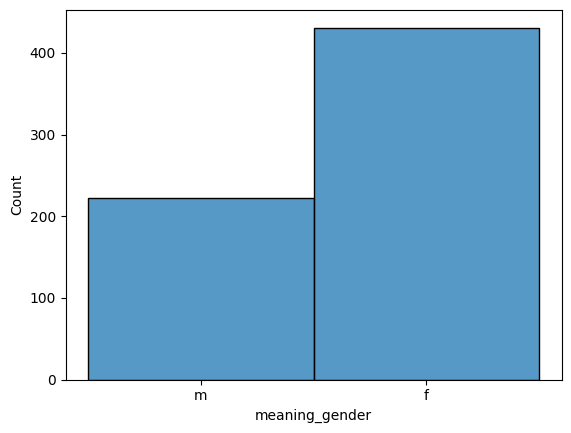

In [19]:
sns.histplot(data[data["household objects"]==1]["meaning_gender"])

In [20]:
popular_endings = []
for n in range(2, 7):
    for item in dict(data[f"last_{n}"].value_counts().head(20)).items():
        if item[0]!="":
            popular_endings.append({
                "ending": item[0],
                "freq": item[1],
                "n": f"last_{n}"
            })
pd.DataFrame(popular_endings).to_csv("popular_endings.csv", index=False)

## Training

### Functions

In [21]:
def fit_predict(model_type, X_train, y_train, X_test, y_test):
    model = model_type
    model.fit(X_train, y_train)
    _y_pred = model.predict(X_test)
    
    return _y_pred, classification_report(y_test, _y_pred, output_dict=True)


def train_models(X_train, y_train,
                 mnb=False, rfc=True, dtc=True, log=False,
                 test_size=0.2, random_state=42,
                 dtc_max_depth=None, dtc_min_samples_leaf=1
                ):
    
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)
    _y_pred, _results, _models = {}, {}, {}
    
    if mnb:
        _models["mnb"] = MultinomialNB()
        _y_pred["MultinomialNB"], _results["MultinomialNB"] = fit_predict(
            _models["mnb"], X_train, y_train, X_test, y_test)
    if rfc:
        _models["rfc"] = RandomForestClassifier()
        _y_pred["RandomForestClassifier"], _results["RandomForestClassifier"] = fit_predict(
            _models["rfc"], X_train, y_train, X_test, y_test)
    if dtc:
        _models["dtc"] = DecisionTreeClassifier(max_depth=dtc_max_depth, min_samples_leaf=dtc_min_samples_leaf)
        _y_pred["DecisionTreeClassifier"], _results["DecisionTreeClassifier"] = fit_predict(
            _models["dtc"], X_train, y_train, X_test, y_test)
    if log:
        _models["log"] = LogisticRegression()
        _y_pred["LogisticRegression"], _results["LogisticRegression"] = fit_predict(
            _models["log"], X_train, y_train, X_test, y_test)

    return _y_pred, _results, _models


def show_accuracy(results):
    return {key: round(results[key]["accuracy"], 3) for key in results.keys()}


def show_importances(model, features, n=20):
    indices = np.argsort(model.feature_importances_)[::-1]
    importances = []
    for f in range(min(n, len(features))):
        importances.append({
            "feature": features[indices[f]],
            "importance": model.feature_importances_[indices[f]]
        })
    return pd.DataFrame(importances, index=range(1, min(n, len(features))+1))

In [22]:
def transform_VECTORIZER(feature, random_state=42):
    return CountVectorizer().fit_transform(data[feature])

In [23]:
def transform_OHE(feature, random_state=42):
    ohe = OneHotEncoder()
    return ohe.fit_transform(data[[feature]]), ohe.get_feature_names_out()

## Training pipeline

In [24]:
RANDOM_STATE = 42

In [25]:
FEATURE = "meaning"
x_transformed[FEATURE] = transform_VECTORIZER(FEATURE)
y_pred[FEATURE], results[FEATURE], _ = train_models(
    x_transformed[FEATURE], data["meaning_gender"], random_state=RANDOM_STATE)

In [26]:
FEATURE = "last_vowel"
x_transformed[FEATURE], vowels_feature_names = transform_OHE(FEATURE)
y_pred[FEATURE], results[FEATURE], models[FEATURE] = train_models(
    x_transformed[FEATURE], data["meaning_gender"], random_state=RANDOM_STATE)

In [27]:
show_importances(models[FEATURE]["dtc"], vowels_feature_names, 5)

,feature,importance
1,last_vowel_i,0.870300
2,last_vowel_o,0.049920
3,last_vowel_u,0.035432
4,last_vowel_ī,0.021893
5,last_vowel_ê,0.011504


In [28]:
for FEATURE in ("last_2", "last_3"):
    x_transformed[FEATURE], word_endings[FEATURE] = transform_OHE(FEATURE)
    y_pred[FEATURE], results[FEATURE], models[FEATURE] = train_models(
        x_transformed[FEATURE], data["meaning_gender"], random_state=RANDOM_STATE)

In [29]:
show_importances(models["last_2"]["dtc"], word_endings["last_2"], 5)

,feature,importance
1,last_2_ri,0.078327
2,last_2_gi,0.043508
3,last_2_ak,0.033372
4,last_2_at,0.025701
5,last_2_di,0.021771


In [30]:
FEATURE = "sem_features"
y_pred[FEATURE], results[FEATURE], models[FEATURE] = train_models(
        data[sem_features], data["meaning_gender"], random_state=RANDOM_STATE)

In [31]:
show_importances(models["sem_features"]["dtc"], sem_features, 5)

,feature,importance
1,"mass,abstr",0.427644
2,sex=f,0.050441
3,household objects,0.046596
4,animals,0.046223
5,cultural prod.,0.041887


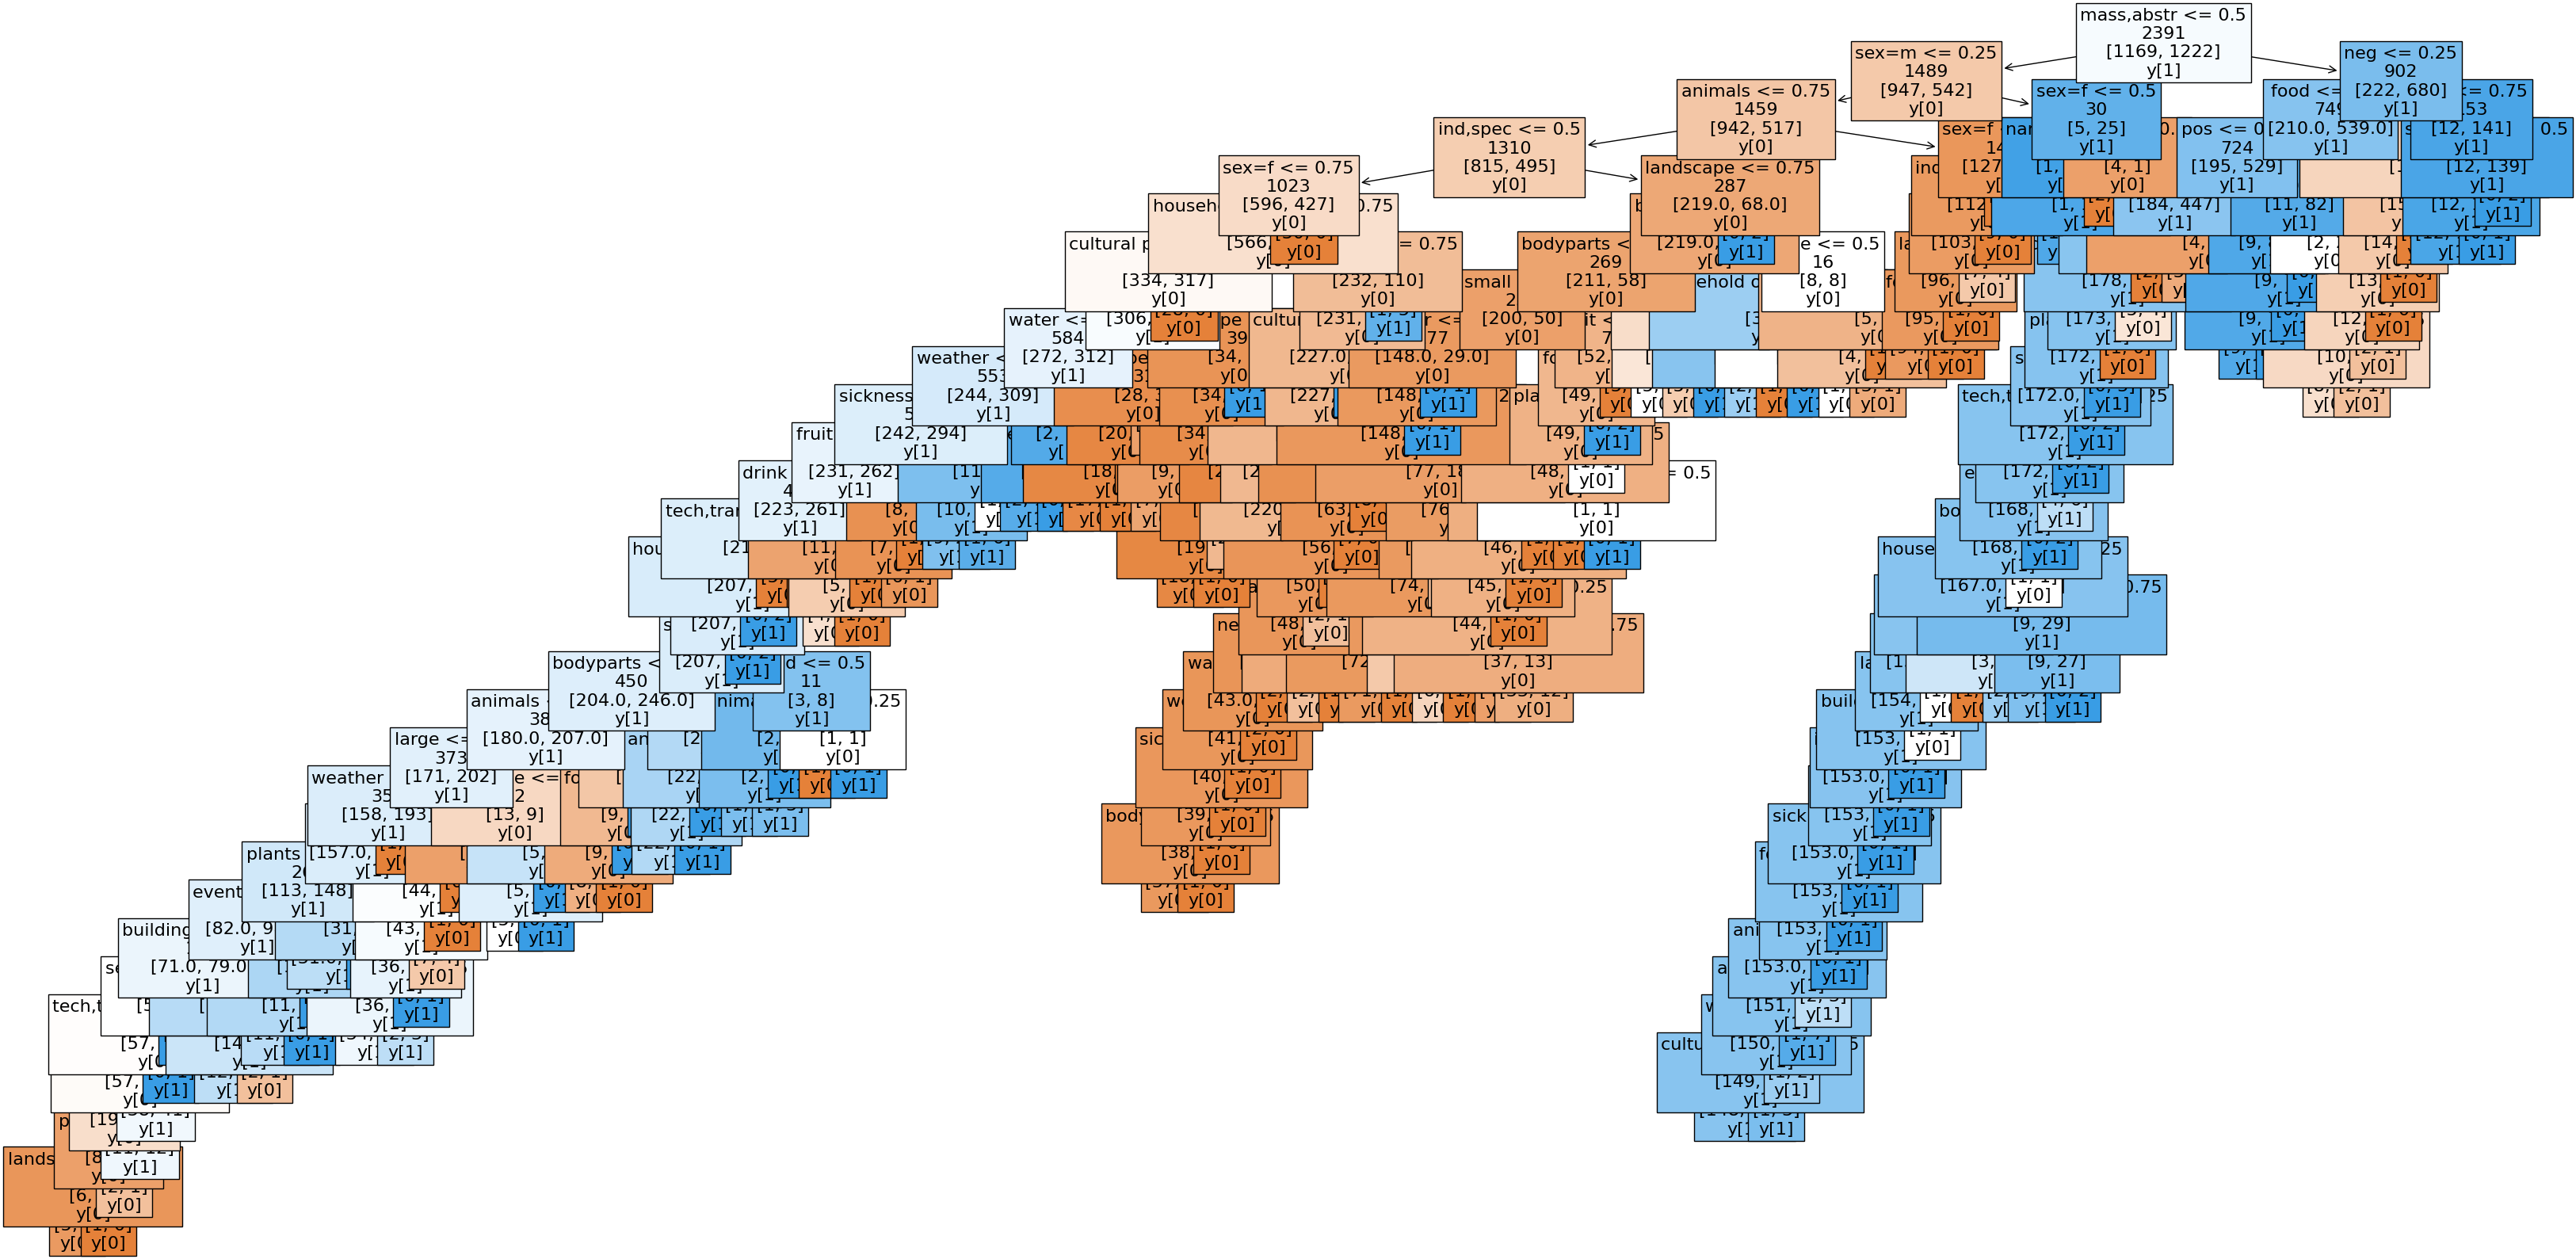

In [32]:
plt.figure(figsize=(40, 20))
plot_tree(models["sem_features"]["dtc"], filled=True, feature_names=sem_features,
          class_names=True, impurity=False, label="none", fontsize=16)
plt.show()

### Stacking features

In [33]:
FEATURE = "sem_features + last_3"
y_pred[FEATURE], results[FEATURE], models[FEATURE] = train_models(
    hstack((data[sem_features], x_transformed["last_3"])),
    data["meaning_gender"], random_state=RANDOM_STATE)

In [34]:
FEATURE = "sem_features + last_vowel + last_3"
y_pred[FEATURE], results[FEATURE], models[FEATURE] = train_models(
    hstack((data[sem_features], x_transformed["last_vowel"], x_transformed["last_3"])),
    data["meaning_gender"], random_state=RANDOM_STATE)

### Comparing features

In [35]:
accuracies = {}
for key in results:
    accuracies[key] = show_accuracy(results[key])
accuracies = pd.DataFrame(accuracies).transpose()
accuracies

,RandomForestClassifier,DecisionTreeClassifier
meaning,0.687,0.689
last_vowel,0.579,0.579
last_2,0.681,0.687
last_3,0.699,0.684
sem_features,0.736,0.736
sem_features + last_3,0.769,0.761
sem_features + last_vowel + last_3,0.774,0.778


<Axes: >

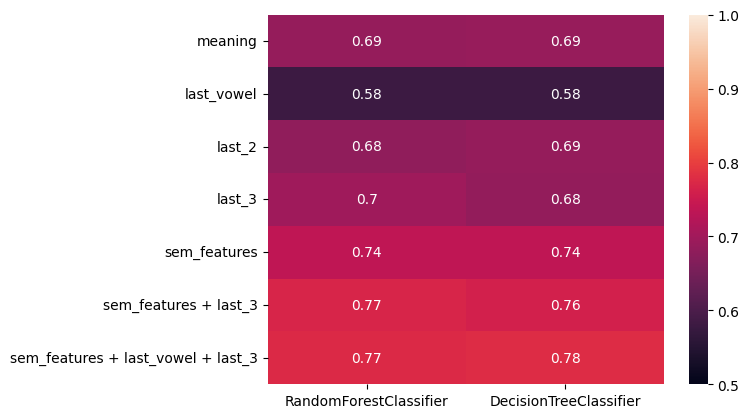

In [38]:
sns.heatmap(accuracies, vmin=0.5, vmax=1, annot=True)

______

### Stacking features (old)

*Ниже этой строчки я кажется ничего не трогал!*

In [ ]:
X = data['meaning']
y = data['grammar']

# Векторизация определений слов
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(X)

# Подготовка семантических признаков
X_semantic = data[['ind,spec', 'large', 'sex=f', 'animals', 'water', 'trees', 'fruit', 'tech,transport', 
                   'cultural prod.', 'mass,abstr', 'small', 'name', 'household objects', 'food', 'drink', 
                   'plants', 'events', 'pos', 'neg', 'weather', 'bodyparts', 'buildings', 'landscape', 
                   'sex=m', 'milk prod.', 'vegetables', 'footwear', 'sicknesses']]

vectorizer3 = CountVectorizer(analyzer='char', ngram_range=(3,3))
X3 = vectorizer3.fit_transform(data['last_3_letters'])

X_combined = hstack((X_vec, X_semantic, X3))

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

rfc_c = RandomForestClassifier()
rfc_c.fit(X_train, y_train)

y_pred = rfc_c.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Decision Tree model: {accuracy}")

In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of Random Forest Classifier model: {accuracy_rf}")

In [ ]:
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train)

y_pred_logreg = logreg_classifier.predict(X_test)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy of Logistic Regression classifier model: {accuracy_logreg}")

In [ ]:
np.random.seed(42)
X = data['meaning']
y = data['grammar']

# Векторизация определений слов
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(X)

# Подготовка семантических признаков
X_semantic = data[['ind,spec', 'large', 'sex=f', 'animals', 'water', 'trees', 'fruit', 'tech,transport', 
                   'cultural prod.', 'mass,abstr', 'small', 'name', 'household objects', 'food', 'drink', 
                   'plants', 'events', 'pos', 'neg', 'weather', 'bodyparts', 'buildings', 'landscape', 
                   'sex=m', 'milk prod.', 'vegetables', 'footwear', 'sicknesses']]

vectorizer3 = CountVectorizer(analyzer='char', ngram_range=(3,3))
X3 = vectorizer3.fit_transform(data['last_3_letters'])

X_combined = hstack((X_vec, X_semantic, X3))

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

rfc_c = RandomForestClassifier()
rfc_c.fit(X_train, y_train)

y_pred = rfc_c.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Decision Tree model: {accuracy}")

In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of Random Forest Classifier model: {accuracy_rf}")

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train, y_train)

y_pred_mlp = mlp_classifier.predict(X_test)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy of MLP Classifier model: {accuracy_mlp}")

In [ ]:
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train)

y_pred_logreg = logreg_classifier.predict(X_test)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy of Logistic Regression classifier model: {accuracy_logreg}")

In [ ]:
print(classification_report(y_test, y_pred_logreg))

In [ ]:
cml = confusion_matrix(y_test, y_pred_logreg, labels=['f',  'fm','m',  ])
cml

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(cml, annot=True, fmt='d', xticklabels=['f',  'fm','m',  ], yticklabels=['f',  'fm','m',  ], cmap='Blues')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.title('Confusion Matrix')
plt.show()